<a href="https://colab.research.google.com/github/AlinaLevitin/MRI_tumour_detection/blob/main/MRI_tumour_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Importing the relevant packages**

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

### **Loading the Data**

In [ ]:
tf.random.set_seed(42)

# preprocess data (scale)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


# Setup paths to our data directory

dir_path = "/content/drive/MyDrive/Colab Notebooks/MiniProjects/MRI_tumour_detection/data/brain_tumor_dataset"

# Import data from directories and trun it into batches with augmented data
training_data = datagen.flow_from_directory(directory=dir_path, batch_size=32, target_size=(224, 224), class_mode='binary', subset="training", seed=42)
validation_data = datagen.flow_from_directory(directory=dir_path, batch_size=32, target_size=(224, 224), class_mode='binary', subset="validation", seed=42)

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


### **Viewing the data**

In [ ]:
def view_random_image(target_dir, target_class):
    # set the target directory
    target_folder = target_dir + "/" + target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    print(random_image)

    # Read in the image and plot it using matplotlib
    image = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(image)
    plt.title(target_class)
    plt.axis('off')
    plt.show()

    # show the shape
    print(f"Image shape: {image.shape}")

    return image

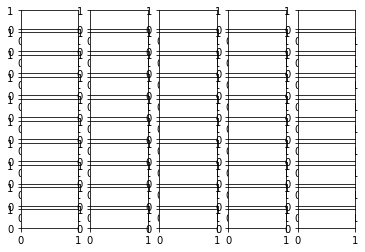

In [ ]:
fig_1, axs = plt.subplots(10, 5)
yes_image = view_random_image(dir_path, 'yes')

### **Preprocessign data**

In [ ]:
# BUILD CNN:

# construct the model
model_1 = tf.keras.models.Sequential([
                                      tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=(224, 224, 3)),
                                      tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
                                      tf.keras.layers.MaxPool2D(pool_size=2, padding='valid'),
                                      tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
                                      tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
                                      tf.keras.layers.MaxPool2D(pool_size=2, padding='valid'),
                                      tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
                                      tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
                                      tf.keras.layers.MaxPool2D(pool_size=2, padding='valid'),
                                      tf.keras.layers.Flatten(),
                                      tf.keras.layers.Dense(1, activation='sigmoid')
                                      ])

# Compile the model
model_1.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])


In [ ]:
# fit the data
history_1 = model_1.fit(training_data, epochs=7, steps_per_epoch=len(training_data))

In [ ]:
model_1.evaluate(validation_data)

In [ ]:
y_pred = model_1.predict(validation_data)

In [ ]:
y_true = validation_data.labels

In [ ]:
y_pred.shape, y_true.shape

In [ ]:
cm = confusion_matrix(y_true, tf.round(y_pred))

In [ ]:
cm